In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the LDS
T = 50      # number of time bins per batch
B = 20      # number of batches
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_lds = ssm.LDS(N, D, emissions="poisson_nn", 
               emission_kwargs=dict(link="softplus", 
                                    hidden_layer_sizes=(50, 50))
              )
true_lds.dynamics.As[0] = .95 * random_rotation(D, theta=(1) * np.pi/20)

# Sample a bunch of short trajectories 
# (they all converge so we only learn from the initial condition)
zs, xs, ys = list(zip(*[true_lds.sample(T) for _ in range(B)]))

Text(0.5,1,'Simulated latent trajectories')

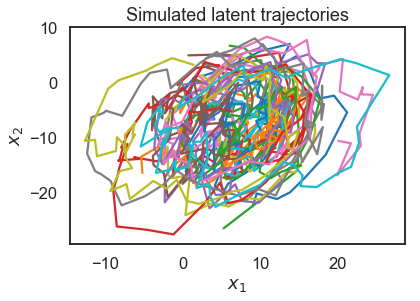

In [4]:
for x in xs:
    plt.plot(x[:, 0], x[:, 1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated latent trajectories")

Text(0.5,0.98,'Simulated firing rates')

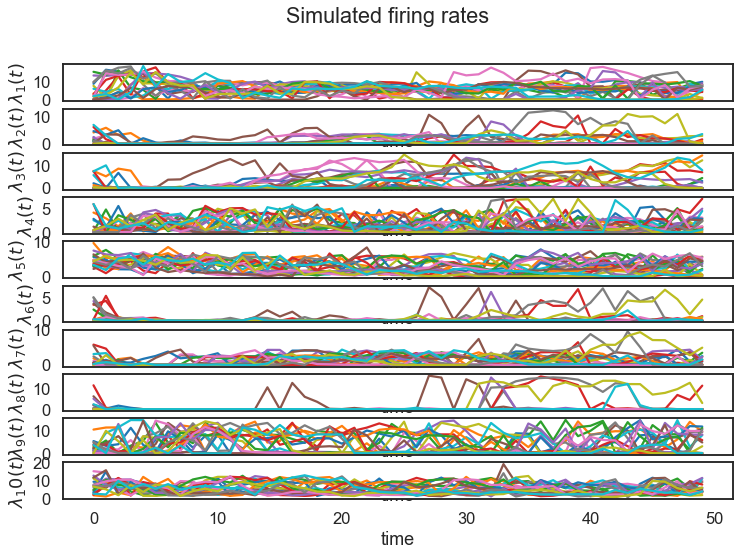

In [5]:
# Compute the firing rates
rates = [true_lds.smooth(x, y) for x, y in zip(xs, ys)]

plt.figure(figsize=(12, 8))
for n in range(N):
    plt.subplot(N, 1, n+1)
    for lmbda in rates:
        plt.plot(lmbda[:, n])
    plt.xlabel("time")
    plt.ylabel("$\\lambda_{}(t)$".format(n+1))
plt.suptitle("Simulated firing rates")

In [6]:
# Plot the nonlinear firing rate map for neuron 1
xmin, xmax = np.concatenate(xs).min(), np.concatenate(xs).max()
npts = 50
xx = np.linspace(xmin-1, xmax+1, npts)
XX, YY = np.meshgrid(xx, xx)
XY = np.column_stack((XX.ravel(), YY.ravel()))
tuning_curves = true_lds.smooth(XY, np.zeros((npts**2, N)))
assert np.all(tuning_curves > 0 )

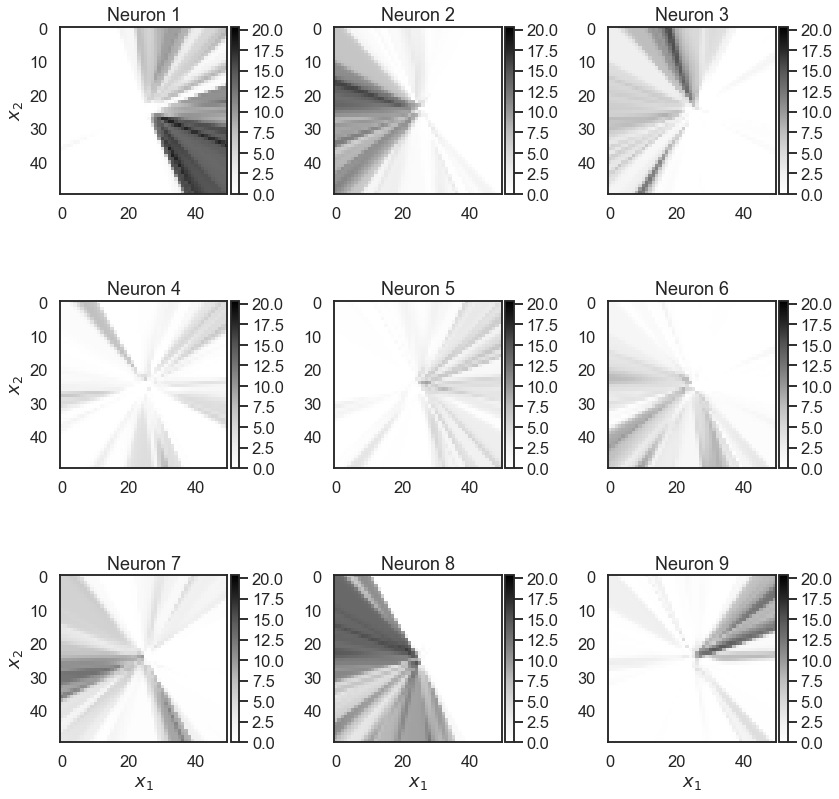

In [7]:
vmax = 1.1 * tuning_curves.max()
plt.figure(figsize=(12, 12))
splt = 3
for i in range(splt):
    for j in range(splt):
        n = i * splt + j 
        if n < N:
            ax = plt.subplot(splt, splt, n+1)
            im = plt.imshow(tuning_curves[:, n].reshape((npts, npts)), vmin=0, vmax=vmax, cmap="Greys")
            if i == splt-1:
                plt.xlabel("$x_1$")
            if j == 0:
                plt.ylabel("$x_2$")
                
            plt.title("Neuron {}".format(n+1))
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
plt.tight_layout()

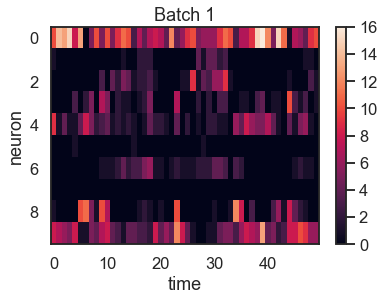

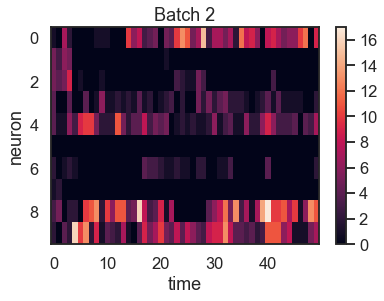

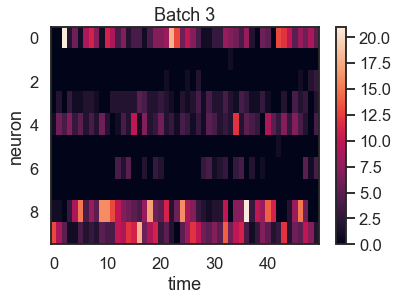

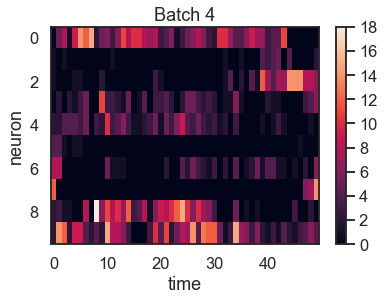

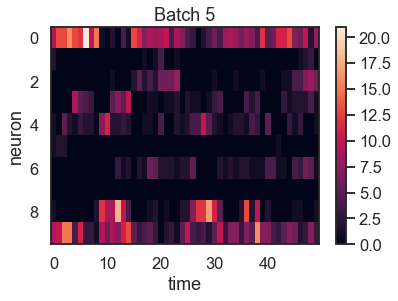

In [8]:
for b in range(5):
    plt.figure()
    plt.imshow(ys[b].T, aspect="auto", interpolation="none")
    plt.xlabel("time")
    plt.ylabel("neuron")
    plt.title("Batch {}".format(b+1))
    plt.colorbar()

In [9]:
print("Fitting LDS with SVI")
lds = ssm.LDS(N, D, emissions="poisson_nn", 
          emission_kwargs=dict(link="softplus", 
                               hidden_layer_sizes=(50, 50))
         )
lds.initialize(ys)

lds_elbos, q = lds.fit(ys, method="bbvi", variational_posterior="mf",
                       num_iters=10000, print_intvl=100, initialize=False)
lds_xs = q.mean

Fitting LDS with SVI
Initializing with an ARHMM using 25 steps of EM.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Text(0,0.5,'ELBO')

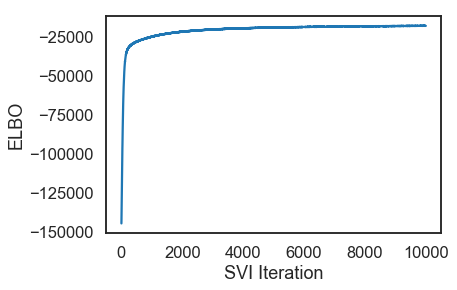

In [10]:
plt.plot(lds_elbos)
plt.xlabel("SVI Iteration")
plt.ylabel("ELBO")

In [11]:
# Smooth the observations
lds_ys = [lds.smooth(x, y) for x, y in zip(lds_xs, ys)]

(0, 50)

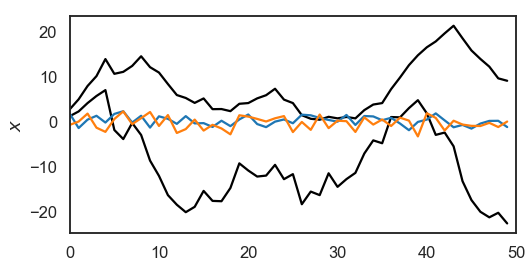

In [12]:
plt.figure(figsize=(8,4))
plt.plot(xs[0], '-k')
plt.plot(lds_xs[0], '-')
plt.ylabel("$x$")
plt.xlim(0, T)

(0, 50)

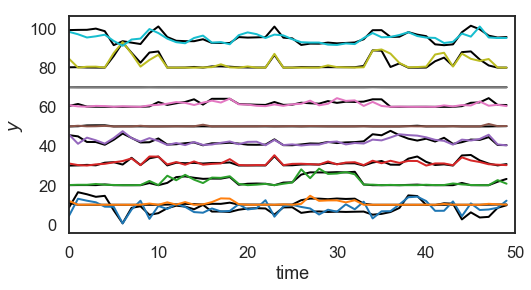

In [13]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
plt.plot(rates[0] + 10 * np.arange(N), '-k', lw=2)
plt.plot(lds_ys[0] + 10 * np.arange(N), '-', lw=2)
plt.ylabel("$y$")
plt.xlabel("time")
plt.xlim(0, T)